In [1]:
import gym
import numpy as np
import math
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class pdController:
    def __init__(self, kp: float, kd: float, set_point=0):
        self.kp, self.kd = kp, kd
        self.set_point = set_point

    def stepController(self, state):
        p = self.kp * (self.set_point - state[0])
        d = self.kd * (0 - state[1])
        torque = p + d

        return np.array([torque])

In [3]:

class PendulumEnv:
    """ Wrapper over the original gym pendulum environment to only return the theta (angle) as observation"""

    def __init__(self):
        self.env = gym.make('Pendulum-v0')

    def seed(self, *args, **kwargs):
        self.env.seed(*args, **kwargs)

    def reset(self):
        obs = self.env.reset()        
        return self.obs2Polar(obs) # convert to polar coord

    def step(self, action, **kwargs):
        #NOTE: very bs thing from gym obs definition, it outputs x, y, velocity, but x and y are actually flipped in coordinate
        # to use the controller, we have to define in joint coordinate, env.env.state returns the angles from -180 to 180
        # idk why they want to define in this way rather than just 0 to 360. 
        # So we use original obs and convert back to polar coordinate in 0 to 360 covnetion. 
        obs, reward, done, info = self.env.step(action, **kwargs)
        return self.obs2Polar(obs), reward, done, info

    def render(self, *args, **kwargs):
        return self.env.render(*args, **kwargs)

    def obs2Polar(self, obs):
        if self.env.state[0] < 0:
            theta = np.pi - np.abs(self.env.state[0]) + np.pi
        else:
            theta = self.env.state[0]
        return np.array([theta, self.env.state[1]])

    # deprecated
    def _get_obs(self):
        theta, dtheta = self.env.state
        return np.array([theta, dtheta])

    def close(self, *args, **kwargs):
        return self.env.close(*args, **kwargs)


In [30]:
# create controller and reset it
pdCtrl = pdController(kp=100, kd=5, set_point=np.deg2rad(150))
# the torque limit on the env is very small, so the PD controller is very hard to balance back to inverted top
# it will most generate the bang-bang control, because it does not know the natural dynamics, basically this is all the algo is doing with direct torque control
# but given a narrow range of initial states, it should work ok. not expect to be anle to solve all. 

In [31]:
# create, initialize and reset the environment.
env = PendulumEnv()
# env.seed(0)
obs = env.reset()

# episode trackers
done = False
episode_reward = 0
ep_obs = []
ep_action =[]
sim_u = []
render = False

if render:
    img = plt.imshow(env.render(mode='rgb_array')) # render window

# interact with the environment till termination.
for _ in range(500):
    # render
    if render:
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)

    # step
    action = pdCtrl.stepController(obs)
    ep_obs.append(math.degrees(obs[0]))
    ep_action.append(action)
    sim_u.append(env.env.last_u)
    obs, reward, done, _ = env.step(action)
    episode_reward += reward

env.close()


### `Plots`

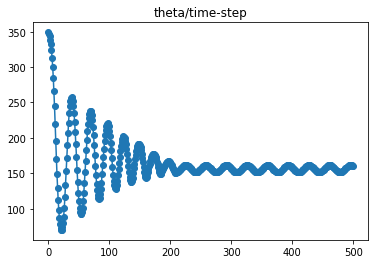

In [32]:
plt.plot(ep_obs,marker='o')
plt.title('theta/time-step')
plt.show()

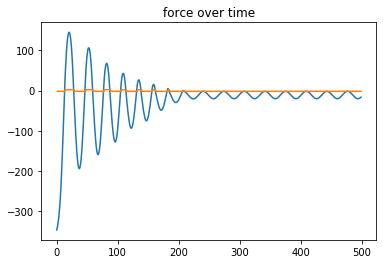

In [33]:
plt.plot(ep_action)
plt.plot(sim_u)
plt.title('force over time')
plt.show()